# Data Set (Training and Test set)

We used IMDb Dataset which can be downloaded from [here](https://ai.stanford.edu/~amaas/data/sentiment/).
This data set contains 50,000 reviews which is evenly split into two groups: 25,000 reviews for each of training and testing. The reviews for training and testing data sets contain a disjoint set of movies. Therefore, we can assume that the validation result with testing data set can be applicable for other movie reviews.

Each group has the same number of positive and negative reviews: a positive review has a score from 7 to 10 while a negative review has a score from 1 to 4. The reviews having score 5 or 6 are excluded to avoid vagueness.


# Environment

For this project, we used my own Linux machine having AMD Ryzen 7 2700X, 16GB Memory, Geforce RTX 2070.
In addition, Keras with Tensorflow backend is used for making a deep learning model.

In [1]:
from string import punctuation
import os 
#from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
#
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
#
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend.tensorflow_backend as K
import tensorflow as tf
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import string
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.tokenize import word_tokenize
import glob
#from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from nltk.stem.porter import PorterStemmer
from collections import Counter
from operator import itemgetter
import numpy as np
from multiprocessing import Pool
import sys

from IPython.display import HTML, display
import tabulate
import pandas as pd
from keras_tqdm import TQDMNotebookCallback


Using TensorFlow backend.


# Tensorflow initial setup

To allow Tensorflow to use enough GPU memory, *allow_growth* option is turned on.

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

# Loading data set files

First of all, all the documents are loaded. The data sets for training and testing are stored in *data/train* and *data/test*, respectively. For each data set, positive and negative reviews are stored in *pos* and *neg* sub-directories.

I have attached the progress bars using the [tqdm](https://github.com/tqdm/tqdm), which is useful in dealting with large data by allowing us to estimate each time of the stages.

Referenced article for tqdm: https://towardsdatascience.com/progress-bars-in-python-4b44e8a4c482

In [3]:
# load all docs in a directory
def load_docs(directory):
    documents = list()
    # walk through all files in the folder
    for filename in tqdm(os.listdir(directory)):
        # create the full path of the file to open
        path = directory + '/' + filename
        with open(path, 'r') as f:
            # load the doc
            doc = f.read()
            # add to list
            documents.append(doc)
    return documents

# load all training reviews
print("Loading training-positive-docs")
global_train_positive_docs = load_docs('data/train/pos')
print("Loading training-negative-docs")
global_train_negative_docs = load_docs('data/train/neg')
# load all test reviews
print("Loading test-positive-docs")
global_test_positive_docs = load_docs('data/test/pos')
print("Loading test-negative-docs")
global_test_negative_docs = load_docs('data/test/neg')

Loading training-positive-docs



Loading training-negative-docs



Loading test-positive-docs



Loading test-negative-docs


# Cleaning documents

### Pre-processing techniques

In most of NLP releated works, documents are normally pre-processed to get better performance.
We tried to apply several techniques which are well-known as follows:

**1. Removing punctuations**  
Normally punctuations do not have any meaning, but they exist for understandability. Therefore, such punctuations should be removed. But, we did not remove the apostrophe mark (') since such removing caused the incorrect stemming.

**2. Removing stopwords**  
We filtered out the stopwords.
The stop words are those words that do not contribute to the deeper meaning of the phrase.
They are the most common words such as: “the“, “a“, and “is“.
NLTK provides a list of commonly agreed upon stop words for a variety of languages.

**3. Stemming**    
The *PorterStemmer* is provided in *NLTK python package*.
We made the words into lowercases and used the stemming method in order to both reduce the vocabulary and to focus on the sense or sentiment of a document rather than deeper meaning.

**4. Removing non-frequent words**   
It is important to define a vocabulary of known words when using a bag-of-words or embedding model.
The more words, the larger the representation of documents, therefore it is important to constrain the words to only those believed to be predictive. 

In this project, **we set up the vocabulary dictionary by removing the non-frequent words to prevent a model from overfitting.** 
This is implemeted in [*vocab.ipynb*](https://github.com/ahrimhan/data-science-project/tree/master/project2/src/vocab.ipynb).

* After removing all words that have a length <= 1 character, we first construct the vocabulary dictionary based on only reviews in the training dataset (Number of vocabularies: 52,826).
* Then, we iterate the vocabulary dictionary again for counting the word occurrences and removing the non-frequent words that have a low occurrence, such as only being used once or none. Thus, remaining vocabularies have the two or more occurrences (Number of filtered vocabularies: 30,819). These filtered vocabularies are saved in [*vocab.txt*](https://github.com/ahrimhan/data-science-project/tree/master/project2/src/vocab.txt).

In [4]:
remove_punctuation_table = str.maketrans('', '', '\'"!.,?:;')
stop_words = set(stopwords.words('english'))
# turn a doc into clean tokens
vocab = []

with open('./vocab/vocab.txt') as f:
    vocab = f.read().split() 
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = word_tokenize(doc)
    
    # remove punctuation from each token
    tokens = [w.translate(remove_punctuation_table) for w in tokens]
    
    # remove stop words
    tokens = [w for w in tokens if w not in stop_words]
    
    # stemming
    porter = PorterStemmer()
    tokens = [porter.stem(w.lower()) for w in tokens]

    # filter out tokens not in vocab
    if len(vocab) > 0:
        tokens = [w for w in tokens if w in vocab]
    
    tokens = ' '.join(tokens)
    return tokens

### Multiprocessing

Pre-processing mentioned above requires heavy computation. 
To improve the speed, we parallelized the pre-processing using the *Pool module* in *multiprocessing package*.
Since we use a CPU having 8 cores, the size of Pool is set as 8.
By using this technique, **we could achieve 6~7 times speed up.** 
Using the single thread, it takes 10~12 minutes for cleaning up 12500 documents, whereas, using the multiple threads, it takes only 1 minute and 20~40 seconds.

In [5]:
# Serial version of clean_docs function
# def clean_docs(documents):
#     for doc in tqdm(documents):
#         clean_doc(doc)

# Parallel version of clean_docs function
def clean_docs(documents):
    # Since we use a CPU having 8 cores, the size of Pool is set as 8
    with Pool(8) as p:
        return list(tqdm(p.imap(clean_doc, documents), total=len(documents)))

print("Cleaning up for training-positive-docs")
cleaned_train_positive_docs = clean_docs(global_train_positive_docs)
print("Cleaning up for training-negative-docs")
cleaned_train_negative_docs = clean_docs(global_train_negative_docs)
print("Cleaning up for test-positive-docs")
cleaned_test_positive_docs = clean_docs(global_test_positive_docs)
print("Cleaning up for test-negative-docs")
cleaned_test_negative_docs = clean_docs(global_test_negative_docs) 

Cleaning up for training-positive-docs



Cleaning up for training-negative-docs



Cleaning up for test-positive-docs



Cleaning up for test-negative-docs


In [6]:
print(cleaned_test_negative_docs[0].split()[0:100])

['nt', 'realli', 'consid', 'conserv', 'nt', 'person', 'offend', 'film', 'pretti', 'clear', 'plot', 'character', 'film', 'secondari', 'messag', 'and', 'messag', 'conserv', 'either', 'evil', 'stupid', 'charact', 'either', 'good', 'american', 'brainless', 'greedi', 'evil', 'conserv', 'there', 'noth', 'clever', 'creativ', 'nt', 'realli', 'mind', 'polit', 'bia', 'nt', 'purpos', 'behind', 'movi', 'and', 'clearli', 'br', 'br', 'on', 'posit', 'side', 'cast', 'wonder', 'chri', 'cooper', 'impress', 'funni', 'first', 'two', 'three', 'time', 'old', 'joke', 'told', 'br', 'br', 'so', 'realli', 'hate', 'conserv', 'probabl', 'enjoy', 'film', 'look', 'someth', 'realist', 'charact', 'stori', 'less', 'better', 'watch', 'someth', 'els']


# Encoding data set into sequence

To use documents as an input of a model, each document is encoded as a sequence object of Keras.
The function below encodes the documents as sequence objects as well as creates a list of labels: '0' for negative reviews and '1' for positive reviews.
We do not need the one hot encoding process (a function called *to_categorical()* in Keras) because there is only two classes of positive and negative.

In [7]:
def encode_data_set(tokenizer, positive_docs, negative_docs, max_word_length):
    docs = negative_docs + positive_docs
    # sequence encode
    encoded_docs = tokenizer.texts_to_sequences(docs)
    # pad sequences
    x = pad_sequences(encoded_docs, maxlen=max_word_length, padding='post')
    # define training labels
    y = array(([0] * len(negative_docs)) + ([1] * len(positive_docs)))
    return x, y

# Word Embedding
Word embedding is a common technique to deal with texts in Deep Learning.
To compare the effectiveness of use of pre-trained word embedding, here, both of pre-trained word embedding and new (not-trained) embedding will be used.

## Pre-trained word embedding
In this project, we will be using GloVe embeddings, which you can read about [here](https://nlp.stanford.edu/projects/glove/). GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics.

Specifically, we will use the 200-dimensional GloVe embeddings of 400k words computed on a 2014 dump of English Wikipedia. You can download them [here](http://nlp.stanford.edu/data/glove.6B.zip).

In addition, to check whether the pre-trained word embedding needs to be trained or not, we made the function below configurable for *trainable* parameter of Embedding object.

In [8]:
EMBEDDING_DIM = 200
def load_pre_trained_embedding(word_index, max_word_length, trainable_for_embedding):
    embeddings_index = {}
    with open('./glove/glove.6B.200d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=max_word_length, weights=[embedding_matrix], trainable=trainable_for_embedding)

## New (not-trained) word embedding
New word embedding is created with no pre-trained weights, and it should be trainable always.

In [9]:
def new_embedding(word_index, max_word_length, trainable_for_embedding):
    # This is new embedding layer, so trainable must be True regardless the value of trainable_for_embedding
    return Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=max_word_length, trainable=True)

# Building a Deep Learning Model

To build a deep learning model, we basically use the sequential model of Keras.

First, the Embedding layer is located. There are two options of setting embedding layers: using the pre-trained word embedding or training new embedding from scratch.

Second, a series of convolution 1D and pooling layers are added according to typical CNN for text analysis. 

In order to check the effects of the number of convolution layers, we made the function below configurable to set the number of additional convolution layers.

Then, after flattening layer, fully connected dense layers are added.
Since this is a binary classification problem, we use the sigmoid function as an activation function for the final dense layer. If you try to predict a score of a review, it would be better to use 'softmax' function as the activation function.

In [10]:
def build_model(word_index, max_word_length, number_of_additional_conv_layers, use_pre_trained_embedding, trainable_for_embedding, number_of_filters, use_dropout):
    # define model
    model = Sequential()
    embedding_func = new_embedding
    if use_pre_trained_embedding: 
        embedding_func = load_pre_trained_embedding
    model.add(embedding_func(word_index, max_word_length, trainable_for_embedding))
    if use_dropout:
        model.add(Dropout(0.5))
    
    for i in range(number_of_additional_conv_layers):
        model.add(Conv1D(filters=number_of_filters, kernel_size=5, activation='relu'))
        model.add(MaxPooling1D(pool_size=5))
        if use_dropout:
            model.add(Dropout(0.5))
    
    model.add(Conv1D(filters=number_of_filters, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=10))
    if use_dropout:
        model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Building Deep Learning Models using Various Parameters

Now, all the functions defined before are combined in the function *build_and_train_model* as below.
To compare ML results under each combination of settings, it takes four parameters, then makes a model and train it according to the parameters. The length of combinations is 12.

The meaning of the parameters are as follows:
* **use_cleaned_docs**: cleaning review documents or not. 
* **number_of_additional_conv_layers**: the number of additional convolution layers. Basically, one convolution layer is used, but if you want to add more convolution layers, set this parameter to 1 or higher number.
* **use_pre_trained_embedding**: Using pre-trained embedding or not. If True, the GloVe embedding will be used as mentioned above.
* **trainable_for_embedding**: Training the embedding layer with training data set or freezing. Note, when using the new embedding layer, then trainable_for_embedding should be True. 

In [11]:
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
#modelpath = "./model/{epoch:02d}-{val_loss:.4f}.hdf5"
modelpath = "./model/{epoch:02d}-{val_acc:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_acc', verbose=1, save_best_only=True)
#early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', patience=10)
early_stopping_callback = EarlyStopping(monitor='val_acc', mode='max', patience=2)

In [12]:
import gc
def build_and_train_model(use_cleaned_docs=False, 
                          number_of_additional_conv_layers=2, 
                          use_pre_trained_embedding=True,
                          trainable_for_embedding=True,
                          number_of_filters=64, 
                          use_dropout=True):
    train_positive_docs = global_train_positive_docs
    train_negative_docs = global_train_negative_docs
    test_positive_docs = global_test_positive_docs
    test_negative_docs = global_test_negative_docs
    
    # clean up documents if required
    if use_cleaned_docs:
        train_positive_docs = cleaned_train_positive_docs
        train_negative_docs = cleaned_train_negative_docs
        test_positive_docs = cleaned_test_positive_docs
        test_negative_docs = cleaned_test_negative_docs
    
    # create the tokenizer
    tokenizer = Tokenizer()
    train_docs = train_positive_docs + train_negative_docs
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    #
    print('Fitted tokenizer on {} documents'.format(tokenizer.document_count))
    #print('{} words in dictionary'.format(tokenizer.num_words))
    print('Top 5 most common words are:', Counter(tokenizer.word_counts).most_common(5))
    
    # calculate maximum length of words in training docs
    max_word_length = max([len(s.split()) for s in train_docs])
    # get word_index
    word_index = tokenizer.word_index
    #print('Found %s unique tokens.' % len(word_index))

    # encode data into two sequences: x = input, y = output
    x_train, y_train = encode_data_set(tokenizer, train_positive_docs, train_negative_docs, max_word_length)
    x_test, y_test = encode_data_set(tokenizer, test_positive_docs, test_negative_docs, max_word_length)

    # build a model
    model = build_model(word_index, max_word_length, number_of_additional_conv_layers, use_pre_trained_embedding, trainable_for_embedding, number_of_filters, use_dropout)
    # fit network (Training)
    history = model.fit(x_train, y_train, epochs=16, verbose=2, validation_data=(x_test, y_test), batch_size=96, callbacks=[TQDMNotebookCallback(), early_stopping_callback, checkpointer])
    # evaluate
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print('Test Accuracy: %.2f%%' % (acc*100))
    
    K.clear_session()
    gc.collect()
    del model
    
    return history

In [13]:
exp_conditions = []
for use_cleaned_docs in [False]:
    for number_of_additional_conv_layers in [2, 0]:
        for use_pre_trained_embedding in [True, False]:
            for trainable_for_embedding in [True, False]:
                if (not use_pre_trained_embedding) and (not trainable_for_embedding):
                    continue
                for number_of_filters in [48, 96]:
                    for use_dropout in [True, False]:
                        exp_conditions.append({
                            'use_cleaned_docs': use_cleaned_docs, 
                            'number_of_additional_conv_layers': number_of_additional_conv_layers,
                            'use_pre_trained_embedding': use_pre_trained_embedding,
                            'trainable_for_embedding': trainable_for_embedding,
                            'number_of_filters': number_of_filters,
                            'use_dropout': use_dropout
                        })
     

columns_display = ['use_cleaned_docs','number_of_additional_conv_layers', 'use_pre_trained_embedding', 'trainable_for_embedding','number_of_filters','use_dropout']
exp_cond_df = pd.DataFrame(exp_conditions, columns=columns_display)
exp_cond_df

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
0,False,2,True,True,48,True
1,False,2,True,True,48,False
2,False,2,True,True,96,True
3,False,2,True,True,96,False
4,False,2,True,False,48,True
5,False,2,True,False,48,False
6,False,2,True,False,96,True
7,False,2,True,False,96,False
8,False,2,False,True,48,True
9,False,2,False,True,48,False


The final combinations are 12, because the cases when no embedding layers 
(`use_pre_trained_embedding`= **False** and `trainable_for_embedding` = **False**)
will produce error and should be eliminated.

In [14]:
print(len(exp_cond_df))

24


In [15]:
exp_result = []
exp_model_config = []

for i, exp_cond in enumerate(exp_conditions):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    K.set_session(sess)
    display(exp_cond_df[i:i+1])
    history = build_and_train_model(**exp_cond)
    print(history)
    exp_result.append(history)


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
0,False,2,True,True,48,True


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2470, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 48)          48048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 493, 48)           0         
_________________________________________________________________
dropou

Epoch 1/16


 - 18s - loss: 0.6961 - acc: 0.5150 - val_loss: 0.6858 - val_acc: 0.6427

Epoch 00001: val_acc improved from -inf to 0.64272, saving model to ./model/01-0.6427.hdf5
Epoch 2/16


 - 16s - loss: 0.5347 - acc: 0.7276 - val_loss: 0.3933 - val_acc: 0.8627

Epoch 00002: val_acc improved from 0.64272 to 0.86272, saving model to ./model/02-0.8627.hdf5
Epoch 3/16


 - 16s - loss: 0.3409 - acc: 0.8569 - val_loss: 0.3251 - val_acc: 0.8830

Epoch 00003: val_acc improved from 0.86272 to 0.88296, saving model to ./model/03-0.8830.hdf5
Epoch 4/16


 - 16s - loss: 0.2689 - acc: 0.8937 - val_loss: 0.3112 - val_acc: 0.8882

Epoch 00004: val_acc improved from 0.88296 to 0.88816, saving model to ./model/04-0.8882.hdf5
Epoch 5/16


 - 16s - loss: 0.2240 - acc: 0.9120 - val_loss: 0.3090 - val_acc: 0.8935

Epoch 00005: val_acc improved from 0.88816 to 0.89348, saving model to ./model/05-0.8935.hdf5
Epoch 6/16


 - 16s - loss: 0.1841 - acc: 0.9312 - val_loss: 0.2888 - val_acc: 0.8840

Epoch 00006: val_acc did not improve from 0.89348
Epoch 7/16


 - 16s - loss: 0.1585 - acc: 0.9398 - val_loss: 0.2822 - val_acc: 0.8874

Epoch 00007: val_acc did not improve from 0.89348

Test Accuracy: 88.74%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
1,False,2,True,True,48,False


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 48)          48048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 493, 48)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 489, 48)           11568     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 97, 48)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 93, 48)            11568 

Epoch 1/16


 - 13s - loss: 0.4439 - acc: 0.7712 - val_loss: 0.2775 - val_acc: 0.8843

Epoch 00001: val_acc did not improve from 0.89348
Epoch 2/16


 - 13s - loss: 0.2101 - acc: 0.9169 - val_loss: 0.2928 - val_acc: 0.8771

Epoch 00002: val_acc did not improve from 0.89348
Epoch 3/16


 - 13s - loss: 0.0995 - acc: 0.9651 - val_loss: 0.2848 - val_acc: 0.8955

Epoch 00003: val_acc improved from 0.89348 to 0.89552, saving model to ./model/03-0.8955.hdf5
Epoch 4/16


 - 13s - loss: 0.0327 - acc: 0.9908 - val_loss: 0.4240 - val_acc: 0.8846

Epoch 00004: val_acc did not improve from 0.89552
Epoch 5/16


 - 13s - loss: 0.0142 - acc: 0.9958 - val_loss: 0.4851 - val_acc: 0.8820

Epoch 00005: val_acc did not improve from 0.89552

Test Accuracy: 88.20%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
2,False,2,True,True,96,True


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2470, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 493, 96)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 493, 96)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 489, 96)           46176 

Epoch 1/16


 - 22s - loss: 0.6888 - acc: 0.5448 - val_loss: 0.6271 - val_acc: 0.6988

Epoch 00001: val_acc did not improve from 0.89552
Epoch 2/16


 - 21s - loss: 0.4250 - acc: 0.8099 - val_loss: 0.3270 - val_acc: 0.8734

Epoch 00002: val_acc did not improve from 0.89552
Epoch 3/16


 - 21s - loss: 0.2924 - acc: 0.8807 - val_loss: 0.3277 - val_acc: 0.8808

Epoch 00003: val_acc did not improve from 0.89552
Epoch 4/16


 - 21s - loss: 0.2332 - acc: 0.9085 - val_loss: 0.2890 - val_acc: 0.8905

Epoch 00004: val_acc did not improve from 0.89552
Epoch 5/16


 - 21s - loss: 0.1900 - acc: 0.9275 - val_loss: 0.2884 - val_acc: 0.8804

Epoch 00005: val_acc did not improve from 0.89552
Epoch 6/16


 - 21s - loss: 0.1556 - acc: 0.9425 - val_loss: 0.2807 - val_acc: 0.8884

Epoch 00006: val_acc did not improve from 0.89552

Test Accuracy: 88.84%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
3,False,2,True,True,96,False


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 493, 96)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 489, 96)           46176     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 97, 96)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 93, 96)            46176 

Epoch 1/16


 - 18s - loss: 0.4058 - acc: 0.8048 - val_loss: 0.2676 - val_acc: 0.8880

Epoch 00001: val_acc did not improve from 0.89552
Epoch 2/16


 - 17s - loss: 0.1982 - acc: 0.9225 - val_loss: 0.2862 - val_acc: 0.8807

Epoch 00002: val_acc did not improve from 0.89552
Epoch 3/16


 - 17s - loss: 0.0912 - acc: 0.9697 - val_loss: 0.3474 - val_acc: 0.8794

Epoch 00003: val_acc did not improve from 0.89552

Test Accuracy: 87.94%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
4,False,2,True,False,48,True


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2470, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 48)          48048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 493, 48)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 493, 48)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 489, 48)           11568 

Epoch 1/16


 - 11s - loss: 0.6995 - acc: 0.5134 - val_loss: 0.6857 - val_acc: 0.6252

Epoch 00001: val_acc did not improve from 0.89552
Epoch 2/16


 - 11s - loss: 0.5833 - acc: 0.6921 - val_loss: 0.5035 - val_acc: 0.8068

Epoch 00002: val_acc did not improve from 0.89552
Epoch 3/16


 - 11s - loss: 0.4803 - acc: 0.7776 - val_loss: 0.4533 - val_acc: 0.8404

Epoch 00003: val_acc did not improve from 0.89552
Epoch 4/16


 - 11s - loss: 0.4379 - acc: 0.8005 - val_loss: 0.4184 - val_acc: 0.8443

Epoch 00004: val_acc did not improve from 0.89552
Epoch 5/16


 - 11s - loss: 0.4248 - acc: 0.8065 - val_loss: 0.3908 - val_acc: 0.8541

Epoch 00005: val_acc did not improve from 0.89552
Epoch 6/16


 - 11s - loss: 0.4069 - acc: 0.8172 - val_loss: 0.4163 - val_acc: 0.8422

Epoch 00006: val_acc did not improve from 0.89552
Epoch 7/16


 - 11s - loss: 0.4001 - acc: 0.8227 - val_loss: 0.3886 - val_acc: 0.8521

Epoch 00007: val_acc did not improve from 0.89552

Test Accuracy: 85.21%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
5,False,2,True,False,48,False


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 48)          48048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 493, 48)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 489, 48)           11568     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 97, 48)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 93, 48)            11568 

Epoch 1/16


 - 9s - loss: 0.4912 - acc: 0.7391 - val_loss: 0.3659 - val_acc: 0.8351

Epoch 00001: val_acc did not improve from 0.89552
Epoch 2/16


 - 9s - loss: 0.3210 - acc: 0.8622 - val_loss: 0.3341 - val_acc: 0.8511

Epoch 00002: val_acc did not improve from 0.89552
Epoch 3/16


 - 9s - loss: 0.2679 - acc: 0.8907 - val_loss: 0.2875 - val_acc: 0.8778

Epoch 00003: val_acc did not improve from 0.89552
Epoch 4/16


 - 9s - loss: 0.2275 - acc: 0.9100 - val_loss: 0.2880 - val_acc: 0.8782

Epoch 00004: val_acc did not improve from 0.89552
Epoch 5/16


 - 9s - loss: 0.1862 - acc: 0.9270 - val_loss: 0.3712 - val_acc: 0.8494

Epoch 00005: val_acc did not improve from 0.89552
Epoch 6/16


 - 9s - loss: 0.1399 - acc: 0.9490 - val_loss: 0.4190 - val_acc: 0.8546

Epoch 00006: val_acc did not improve from 0.89552

Test Accuracy: 85.46%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
6,False,2,True,False,96,True


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2470, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 493, 96)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 493, 96)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 489, 96)           46176 

Epoch 1/16


 - 15s - loss: 0.7004 - acc: 0.5090 - val_loss: 0.6863 - val_acc: 0.6298

Epoch 00001: val_acc did not improve from 0.89552
Epoch 2/16


 - 15s - loss: 0.5429 - acc: 0.7206 - val_loss: 0.4508 - val_acc: 0.8255

Epoch 00002: val_acc did not improve from 0.89552
Epoch 3/16


 - 15s - loss: 0.4410 - acc: 0.8001 - val_loss: 0.3827 - val_acc: 0.8506

Epoch 00003: val_acc did not improve from 0.89552
Epoch 4/16


 - 15s - loss: 0.4167 - acc: 0.8109 - val_loss: 0.3917 - val_acc: 0.8463

Epoch 00004: val_acc did not improve from 0.89552
Epoch 5/16


 - 15s - loss: 0.3925 - acc: 0.8269 - val_loss: 0.3500 - val_acc: 0.8614

Epoch 00005: val_acc did not improve from 0.89552
Epoch 6/16


 - 15s - loss: 0.3812 - acc: 0.8316 - val_loss: 0.3398 - val_acc: 0.8666

Epoch 00006: val_acc did not improve from 0.89552
Epoch 7/16


 - 15s - loss: 0.3765 - acc: 0.8362 - val_loss: 0.3370 - val_acc: 0.8716

Epoch 00007: val_acc did not improve from 0.89552
Epoch 8/16


 - 15s - loss: 0.3618 - acc: 0.8449 - val_loss: 0.3226 - val_acc: 0.8720

Epoch 00008: val_acc did not improve from 0.89552
Epoch 9/16


 - 15s - loss: 0.3583 - acc: 0.8464 - val_loss: 0.3367 - val_acc: 0.8709

Epoch 00009: val_acc did not improve from 0.89552
Epoch 10/16


 - 15s - loss: 0.3524 - acc: 0.8478 - val_loss: 0.3222 - val_acc: 0.8725

Epoch 00010: val_acc did not improve from 0.89552
Epoch 11/16


 - 15s - loss: 0.3444 - acc: 0.8506 - val_loss: 0.3179 - val_acc: 0.8742

Epoch 00011: val_acc did not improve from 0.89552
Epoch 12/16


 - 15s - loss: 0.3425 - acc: 0.8525 - val_loss: 0.3178 - val_acc: 0.8782

Epoch 00012: val_acc did not improve from 0.89552
Epoch 13/16


 - 15s - loss: 0.3376 - acc: 0.8561 - val_loss: 0.3157 - val_acc: 0.8818

Epoch 00013: val_acc did not improve from 0.89552
Epoch 14/16


 - 15s - loss: 0.3342 - acc: 0.8570 - val_loss: 0.3105 - val_acc: 0.8813

Epoch 00014: val_acc did not improve from 0.89552
Epoch 15/16


 - 15s - loss: 0.3249 - acc: 0.8607 - val_loss: 0.3133 - val_acc: 0.8814

Epoch 00015: val_acc did not improve from 0.89552

Test Accuracy: 88.14%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
7,False,2,True,False,96,False


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 493, 96)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 489, 96)           46176     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 97, 96)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 93, 96)            46176 

Epoch 1/16


 - 13s - loss: 0.4936 - acc: 0.7365 - val_loss: 0.3611 - val_acc: 0.8400

Epoch 00001: val_acc did not improve from 0.89552
Epoch 2/16


 - 13s - loss: 0.3088 - acc: 0.8702 - val_loss: 0.2879 - val_acc: 0.8801

Epoch 00002: val_acc did not improve from 0.89552
Epoch 3/16


 - 13s - loss: 0.2443 - acc: 0.9015 - val_loss: 0.2674 - val_acc: 0.8874

Epoch 00003: val_acc did not improve from 0.89552
Epoch 4/16


 - 13s - loss: 0.1950 - acc: 0.9230 - val_loss: 0.2986 - val_acc: 0.8819

Epoch 00004: val_acc did not improve from 0.89552
Epoch 5/16


 - 13s - loss: 0.1276 - acc: 0.9542 - val_loss: 0.3973 - val_acc: 0.8645

Epoch 00005: val_acc did not improve from 0.89552

Test Accuracy: 86.45%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
8,False,2,False,True,48,True


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2470, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 48)          48048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 493, 48)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 493, 48)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 489, 48)           11568 

Epoch 1/16


 - 17s - loss: 0.6941 - acc: 0.5051 - val_loss: 0.6924 - val_acc: 0.5142

Epoch 00001: val_acc did not improve from 0.89552
Epoch 2/16


 - 17s - loss: 0.4792 - acc: 0.7451 - val_loss: 0.3114 - val_acc: 0.8814

Epoch 00002: val_acc did not improve from 0.89552
Epoch 3/16


 - 17s - loss: 0.2215 - acc: 0.9167 - val_loss: 0.2851 - val_acc: 0.8851

Epoch 00003: val_acc did not improve from 0.89552
Epoch 4/16


 - 17s - loss: 0.1247 - acc: 0.9556 - val_loss: 0.3352 - val_acc: 0.8638

Epoch 00004: val_acc did not improve from 0.89552
Epoch 5/16


 - 17s - loss: 0.0766 - acc: 0.9738 - val_loss: 0.3518 - val_acc: 0.8648

Epoch 00005: val_acc did not improve from 0.89552

Test Accuracy: 86.48%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
9,False,2,False,True,48,False


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 48)          48048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 493, 48)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 489, 48)           11568     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 97, 48)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 93, 48)            11568 

Epoch 1/16


 - 13s - loss: 0.4346 - acc: 0.7581 - val_loss: 0.2737 - val_acc: 0.8877

Epoch 00001: val_acc did not improve from 0.89552
Epoch 2/16


 - 13s - loss: 0.1414 - acc: 0.9486 - val_loss: 0.2840 - val_acc: 0.8820

Epoch 00002: val_acc did not improve from 0.89552
Epoch 3/16


 - 13s - loss: 0.0360 - acc: 0.9890 - val_loss: 0.4140 - val_acc: 0.8728

Epoch 00003: val_acc did not improve from 0.89552

Test Accuracy: 87.28%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
10,False,2,False,True,96,True


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2470, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 493, 96)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 493, 96)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 489, 96)           46176 

Epoch 1/16


 - 22s - loss: 0.6917 - acc: 0.5141 - val_loss: 0.6265 - val_acc: 0.6065

Epoch 00001: val_acc did not improve from 0.89552
Epoch 2/16


 - 21s - loss: 0.3551 - acc: 0.8476 - val_loss: 0.2953 - val_acc: 0.8823

Epoch 00002: val_acc did not improve from 0.89552
Epoch 3/16


 - 21s - loss: 0.1678 - acc: 0.9376 - val_loss: 0.2974 - val_acc: 0.8786

Epoch 00003: val_acc did not improve from 0.89552
Epoch 4/16


 - 21s - loss: 0.0904 - acc: 0.9682 - val_loss: 0.3440 - val_acc: 0.8661

Epoch 00004: val_acc did not improve from 0.89552

Test Accuracy: 86.61%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
11,False,2,False,True,96,False


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 493, 96)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 489, 96)           46176     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 97, 96)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 93, 96)            46176 

Epoch 1/16


 - 18s - loss: 0.4174 - acc: 0.7770 - val_loss: 0.2865 - val_acc: 0.8802

Epoch 00001: val_acc did not improve from 0.89552
Epoch 2/16


 - 17s - loss: 0.1322 - acc: 0.9525 - val_loss: 0.3041 - val_acc: 0.8800

Epoch 00002: val_acc did not improve from 0.89552
Epoch 3/16


 - 17s - loss: 0.0290 - acc: 0.9918 - val_loss: 0.4271 - val_acc: 0.8739

Epoch 00003: val_acc did not improve from 0.89552

Test Accuracy: 87.39%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
12,False,0,True,True,48,True


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2470, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 48)          48048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 246, 48)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 246, 48)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11808)             0     

Epoch 1/16


 - 16s - loss: 0.6826 - acc: 0.5668 - val_loss: 0.5641 - val_acc: 0.7541

Epoch 00001: val_acc did not improve from 0.89552
Epoch 2/16


 - 15s - loss: 0.3898 - acc: 0.8383 - val_loss: 0.2964 - val_acc: 0.8795

Epoch 00002: val_acc did not improve from 0.89552
Epoch 3/16


 - 16s - loss: 0.2554 - acc: 0.8961 - val_loss: 0.2954 - val_acc: 0.8733

Epoch 00003: val_acc did not improve from 0.89552
Epoch 4/16


 - 16s - loss: 0.1991 - acc: 0.9214 - val_loss: 0.2602 - val_acc: 0.8958

Epoch 00004: val_acc improved from 0.89552 to 0.89576, saving model to ./model/04-0.8958.hdf5
Epoch 5/16


 - 15s - loss: 0.1531 - acc: 0.9424 - val_loss: 0.2622 - val_acc: 0.8964

Epoch 00005: val_acc improved from 0.89576 to 0.89644, saving model to ./model/05-0.8964.hdf5
Epoch 6/16


 - 15s - loss: 0.1233 - acc: 0.9539 - val_loss: 0.2740 - val_acc: 0.8892

Epoch 00006: val_acc did not improve from 0.89644
Epoch 7/16


 - 16s - loss: 0.0946 - acc: 0.9658 - val_loss: 0.2929 - val_acc: 0.8842

Epoch 00007: val_acc did not improve from 0.89644

Test Accuracy: 88.42%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
13,False,0,True,True,48,False


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 48)          48048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 246, 48)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11808)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                755776    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65    

Epoch 1/16


 - 12s - loss: 0.4316 - acc: 0.7898 - val_loss: 0.3206 - val_acc: 0.8624

Epoch 00001: val_acc did not improve from 0.89644
Epoch 2/16


 - 12s - loss: 0.1938 - acc: 0.9259 - val_loss: 0.2866 - val_acc: 0.8838

Epoch 00002: val_acc did not improve from 0.89644
Epoch 3/16


 - 12s - loss: 0.0765 - acc: 0.9752 - val_loss: 0.3740 - val_acc: 0.8707

Epoch 00003: val_acc did not improve from 0.89644
Epoch 4/16


 - 12s - loss: 0.0188 - acc: 0.9967 - val_loss: 0.4158 - val_acc: 0.8790

Epoch 00004: val_acc did not improve from 0.89644

Test Accuracy: 87.90%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
14,False,0,True,True,96,True


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2470, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 246, 96)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 246, 96)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23616)             0     

Epoch 1/16


 - 20s - loss: 0.7095 - acc: 0.5078 - val_loss: 0.6892 - val_acc: 0.5745

Epoch 00001: val_acc did not improve from 0.89644
Epoch 2/16


 - 19s - loss: 0.5639 - acc: 0.7509 - val_loss: 0.4604 - val_acc: 0.8689

Epoch 00002: val_acc did not improve from 0.89644
Epoch 3/16


 - 19s - loss: 0.4080 - acc: 0.8775 - val_loss: 0.3891 - val_acc: 0.8870

Epoch 00003: val_acc did not improve from 0.89644
Epoch 4/16


 - 19s - loss: 0.3279 - acc: 0.9060 - val_loss: 0.2839 - val_acc: 0.8862

Epoch 00004: val_acc did not improve from 0.89644
Epoch 5/16


 - 19s - loss: 0.1953 - acc: 0.9273 - val_loss: 0.2811 - val_acc: 0.8870

Epoch 00005: val_acc did not improve from 0.89644

Test Accuracy: 88.70%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
15,False,0,True,True,96,False


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 246, 96)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23616)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1511488   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65    

Epoch 1/16


 - 16s - loss: 0.4721 - acc: 0.7590 - val_loss: 0.2879 - val_acc: 0.8792

Epoch 00001: val_acc did not improve from 0.89644
Epoch 2/16


 - 16s - loss: 0.2036 - acc: 0.9207 - val_loss: 0.2740 - val_acc: 0.8886

Epoch 00002: val_acc did not improve from 0.89644
Epoch 3/16


 - 16s - loss: 0.0807 - acc: 0.9745 - val_loss: 0.3251 - val_acc: 0.8864

Epoch 00003: val_acc did not improve from 0.89644
Epoch 4/16


 - 16s - loss: 0.0218 - acc: 0.9949 - val_loss: 0.3936 - val_acc: 0.8843

Epoch 00004: val_acc did not improve from 0.89644

Test Accuracy: 88.43%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
16,False,0,True,False,48,True


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2470, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 48)          48048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 246, 48)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 246, 48)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11808)             0     

Epoch 1/16


 - 10s - loss: 0.6749 - acc: 0.5612 - val_loss: 0.5198 - val_acc: 0.7723

Epoch 00001: val_acc did not improve from 0.89644
Epoch 2/16


 - 10s - loss: 0.4669 - acc: 0.7810 - val_loss: 0.3853 - val_acc: 0.8419

Epoch 00002: val_acc did not improve from 0.89644
Epoch 3/16


 - 10s - loss: 0.4122 - acc: 0.8125 - val_loss: 0.3798 - val_acc: 0.8298

Epoch 00003: val_acc did not improve from 0.89644
Epoch 4/16


 - 10s - loss: 0.3953 - acc: 0.8225 - val_loss: 0.3722 - val_acc: 0.8322

Epoch 00004: val_acc did not improve from 0.89644

Test Accuracy: 83.22%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
17,False,0,True,False,48,False


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 48)          48048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 246, 48)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11808)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                755776    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65    

Epoch 1/16


 - 8s - loss: 0.4990 - acc: 0.7458 - val_loss: 0.3892 - val_acc: 0.8225

Epoch 00001: val_acc did not improve from 0.89644
Epoch 2/16


 - 8s - loss: 0.3255 - acc: 0.8618 - val_loss: 0.3232 - val_acc: 0.8619

Epoch 00002: val_acc did not improve from 0.89644
Epoch 3/16


 - 8s - loss: 0.2579 - acc: 0.8957 - val_loss: 0.3344 - val_acc: 0.8575

Epoch 00003: val_acc did not improve from 0.89644
Epoch 4/16


 - 8s - loss: 0.1864 - acc: 0.9285 - val_loss: 0.3411 - val_acc: 0.8617

Epoch 00004: val_acc did not improve from 0.89644

Test Accuracy: 86.17%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
18,False,0,True,False,96,True


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2470, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 246, 96)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 246, 96)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23616)             0     

Epoch 1/16


 - 13s - loss: 0.6995 - acc: 0.5202 - val_loss: 0.6850 - val_acc: 0.6134

Epoch 00001: val_acc did not improve from 0.89644
Epoch 2/16


 - 13s - loss: 0.5440 - acc: 0.7462 - val_loss: 0.4127 - val_acc: 0.8336

Epoch 00002: val_acc did not improve from 0.89644
Epoch 3/16


 - 13s - loss: 0.4169 - acc: 0.8117 - val_loss: 0.3636 - val_acc: 0.8521

Epoch 00003: val_acc did not improve from 0.89644
Epoch 4/16


 - 13s - loss: 0.3807 - acc: 0.8298 - val_loss: 0.3414 - val_acc: 0.8592

Epoch 00004: val_acc did not improve from 0.89644
Epoch 5/16


 - 13s - loss: 0.3701 - acc: 0.8381 - val_loss: 0.3351 - val_acc: 0.8649

Epoch 00005: val_acc did not improve from 0.89644
Epoch 6/16


 - 13s - loss: 0.3524 - acc: 0.8446 - val_loss: 0.3259 - val_acc: 0.8681

Epoch 00006: val_acc did not improve from 0.89644
Epoch 7/16


 - 13s - loss: 0.3456 - acc: 0.8498 - val_loss: 0.3271 - val_acc: 0.8599

Epoch 00007: val_acc did not improve from 0.89644
Epoch 8/16


 - 13s - loss: 0.3362 - acc: 0.8563 - val_loss: 0.3156 - val_acc: 0.8705

Epoch 00008: val_acc did not improve from 0.89644
Epoch 9/16


 - 13s - loss: 0.3235 - acc: 0.8591 - val_loss: 0.3114 - val_acc: 0.8732

Epoch 00009: val_acc did not improve from 0.89644
Epoch 10/16


 - 13s - loss: 0.3176 - acc: 0.8640 - val_loss: 0.3042 - val_acc: 0.8726

Epoch 00010: val_acc did not improve from 0.89644
Epoch 11/16


 - 13s - loss: 0.3104 - acc: 0.8678 - val_loss: 0.3059 - val_acc: 0.8746

Epoch 00011: val_acc did not improve from 0.89644
Epoch 12/16


 - 13s - loss: 0.3042 - acc: 0.8712 - val_loss: 0.3019 - val_acc: 0.8756

Epoch 00012: val_acc did not improve from 0.89644
Epoch 13/16


 - 13s - loss: 0.3043 - acc: 0.8709 - val_loss: 0.3062 - val_acc: 0.8737

Epoch 00013: val_acc did not improve from 0.89644
Epoch 14/16


 - 13s - loss: 0.2962 - acc: 0.8730 - val_loss: 0.2992 - val_acc: 0.8763

Epoch 00014: val_acc did not improve from 0.89644
Epoch 15/16


 - 13s - loss: 0.2873 - acc: 0.8788 - val_loss: 0.2998 - val_acc: 0.8739

Epoch 00015: val_acc did not improve from 0.89644
Epoch 16/16


 - 13s - loss: 0.2913 - acc: 0.8770 - val_loss: 0.3020 - val_acc: 0.8731

Epoch 00016: val_acc did not improve from 0.89644

Test Accuracy: 87.31%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
19,False,0,True,False,96,False


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 246, 96)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23616)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1511488   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65    

Epoch 1/16


 - 11s - loss: 0.6146 - acc: 0.6370 - val_loss: 0.4305 - val_acc: 0.8119

Epoch 00001: val_acc did not improve from 0.89644
Epoch 2/16


 - 11s - loss: 0.3682 - acc: 0.8454 - val_loss: 0.3459 - val_acc: 0.8552

Epoch 00002: val_acc did not improve from 0.89644
Epoch 3/16


 - 11s - loss: 0.2987 - acc: 0.8768 - val_loss: 0.3173 - val_acc: 0.8676

Epoch 00003: val_acc did not improve from 0.89644
Epoch 4/16


 - 11s - loss: 0.2294 - acc: 0.9122 - val_loss: 0.3202 - val_acc: 0.8678

Epoch 00004: val_acc did not improve from 0.89644
Epoch 5/16


 - 11s - loss: 0.1579 - acc: 0.9462 - val_loss: 0.3296 - val_acc: 0.8681

Epoch 00005: val_acc did not improve from 0.89644
Epoch 6/16


 - 11s - loss: 0.0962 - acc: 0.9731 - val_loss: 0.4231 - val_acc: 0.8488

Epoch 00006: val_acc did not improve from 0.89644
Epoch 7/16


 - 11s - loss: 0.0557 - acc: 0.9880 - val_loss: 0.4292 - val_acc: 0.8552

Epoch 00007: val_acc did not improve from 0.89644

Test Accuracy: 85.52%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
20,False,0,False,True,48,True


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2470, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 48)          48048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 246, 48)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 246, 48)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11808)             0     

Epoch 1/16


 - 16s - loss: 0.5752 - acc: 0.6456 - val_loss: 0.2995 - val_acc: 0.8760

Epoch 00001: val_acc did not improve from 0.89644
Epoch 2/16


 - 16s - loss: 0.2253 - acc: 0.9117 - val_loss: 0.2778 - val_acc: 0.8845

Epoch 00002: val_acc did not improve from 0.89644
Epoch 3/16


 - 16s - loss: 0.1084 - acc: 0.9607 - val_loss: 0.3375 - val_acc: 0.8731

Epoch 00003: val_acc did not improve from 0.89644
Epoch 4/16


 - 16s - loss: 0.0516 - acc: 0.9820 - val_loss: 0.4285 - val_acc: 0.8673

Epoch 00004: val_acc did not improve from 0.89644

Test Accuracy: 86.73%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
21,False,0,False,True,48,False


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 48)          48048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 246, 48)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11808)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                755776    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65    

Epoch 1/16


 - 13s - loss: 0.4368 - acc: 0.7716 - val_loss: 0.3276 - val_acc: 0.8596

Epoch 00001: val_acc did not improve from 0.89644
Epoch 2/16


 - 12s - loss: 0.1490 - acc: 0.9472 - val_loss: 0.3130 - val_acc: 0.8778

Epoch 00002: val_acc did not improve from 0.89644
Epoch 3/16


 - 12s - loss: 0.0417 - acc: 0.9886 - val_loss: 0.4338 - val_acc: 0.8712

Epoch 00003: val_acc did not improve from 0.89644
Epoch 4/16


 - 12s - loss: 0.0110 - acc: 0.9972 - val_loss: 0.5539 - val_acc: 0.8671

Epoch 00004: val_acc did not improve from 0.89644

Test Accuracy: 86.71%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
22,False,0,False,True,96,True


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2470, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 246, 96)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 246, 96)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23616)             0     

Epoch 1/16


 - 20s - loss: 0.6967 - acc: 0.5056 - val_loss: 0.6866 - val_acc: 0.5822

Epoch 00001: val_acc did not improve from 0.89644
Epoch 2/16


 - 19s - loss: 0.3821 - acc: 0.8157 - val_loss: 0.2733 - val_acc: 0.8888

Epoch 00002: val_acc did not improve from 0.89644
Epoch 3/16


 - 19s - loss: 0.1486 - acc: 0.9468 - val_loss: 0.2985 - val_acc: 0.8815

Epoch 00003: val_acc did not improve from 0.89644
Epoch 4/16


 - 19s - loss: 0.0691 - acc: 0.9763 - val_loss: 0.3790 - val_acc: 0.8722

Epoch 00004: val_acc did not improve from 0.89644

Test Accuracy: 87.22%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout
23,False,0,False,True,96,False


Fitted tokenizer on 25000 documents
Top 5 most common words are: [('the', 336148), ('and', 164097), ('a', 163040), ('of', 145847), ('to', 135708)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 200)         17716600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2466, 96)          96096     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 246, 96)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23616)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1511488   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65    

Epoch 1/16


 - 16s - loss: 0.4289 - acc: 0.7773 - val_loss: 0.2818 - val_acc: 0.8839

Epoch 00001: val_acc did not improve from 0.89644
Epoch 2/16


 - 16s - loss: 0.1470 - acc: 0.9470 - val_loss: 0.2989 - val_acc: 0.8791

Epoch 00002: val_acc did not improve from 0.89644
Epoch 3/16


 - 16s - loss: 0.0439 - acc: 0.9864 - val_loss: 0.4260 - val_acc: 0.8700

Epoch 00003: val_acc did not improve from 0.89644

Test Accuracy: 87.00%


,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,2,True,True,48,True,0.88736


<IPython.core.display.Javascript object>


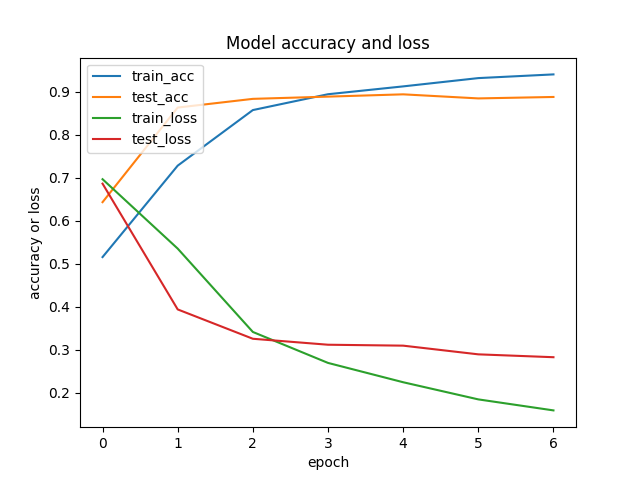

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,2,True,True,48,False,0.88204


<IPython.core.display.Javascript object>


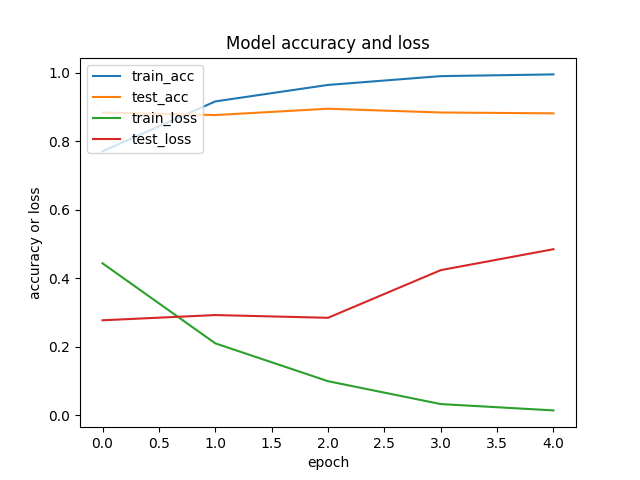

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,2,True,True,96,True,0.88836


<IPython.core.display.Javascript object>


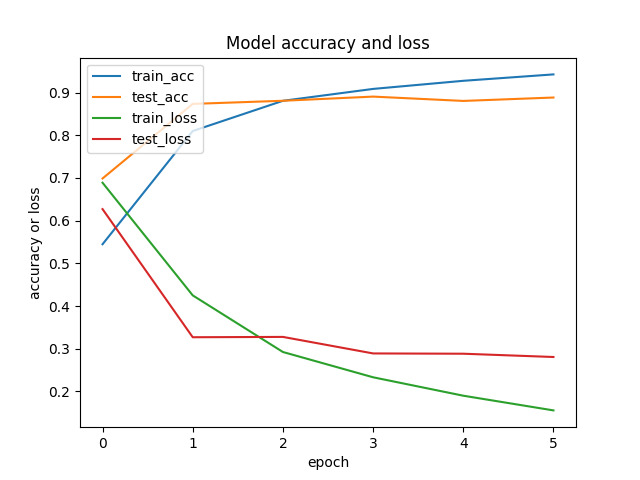

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,2,True,True,96,False,0.87944


<IPython.core.display.Javascript object>


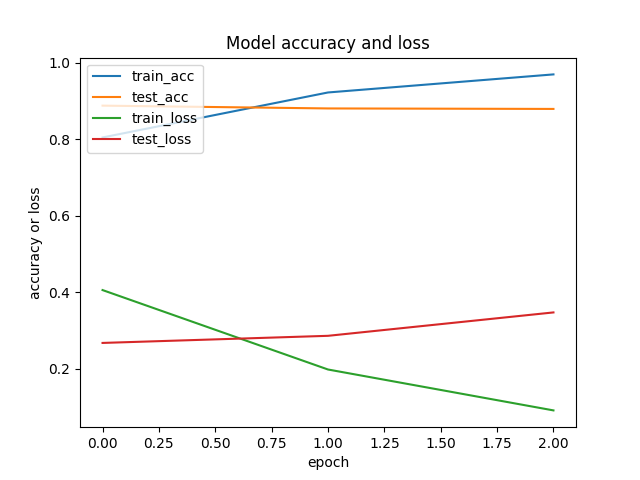

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,2,True,False,48,True,0.85208


<IPython.core.display.Javascript object>


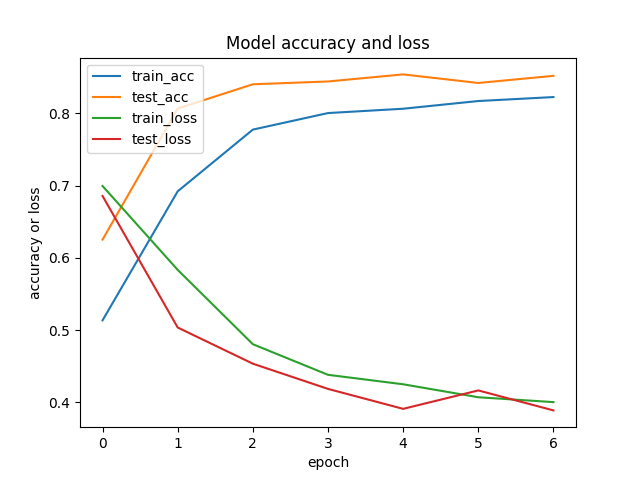

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,2,True,False,48,False,0.85464


<IPython.core.display.Javascript object>


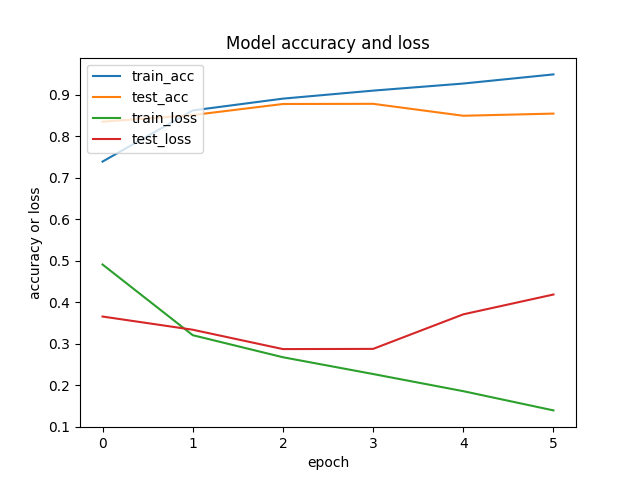

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,2,True,False,96,True,0.8814


<IPython.core.display.Javascript object>


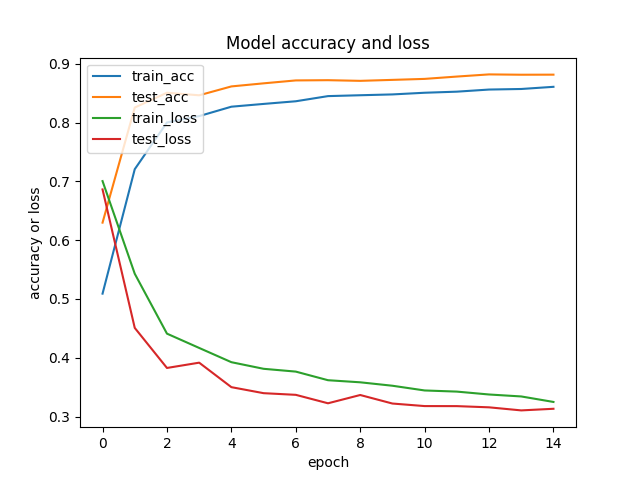

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,2,True,False,96,False,0.86448


<IPython.core.display.Javascript object>


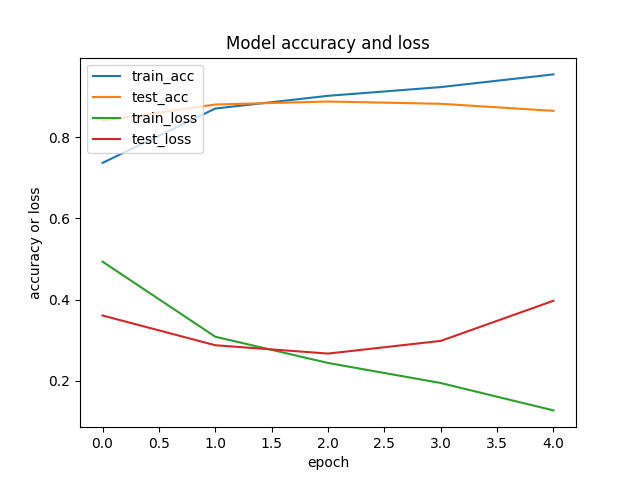

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,2,False,True,48,True,0.86484


<IPython.core.display.Javascript object>


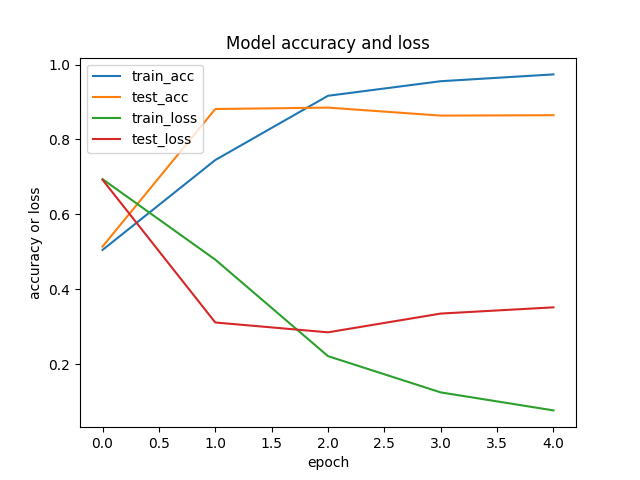

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,2,False,True,48,False,0.87276


<IPython.core.display.Javascript object>


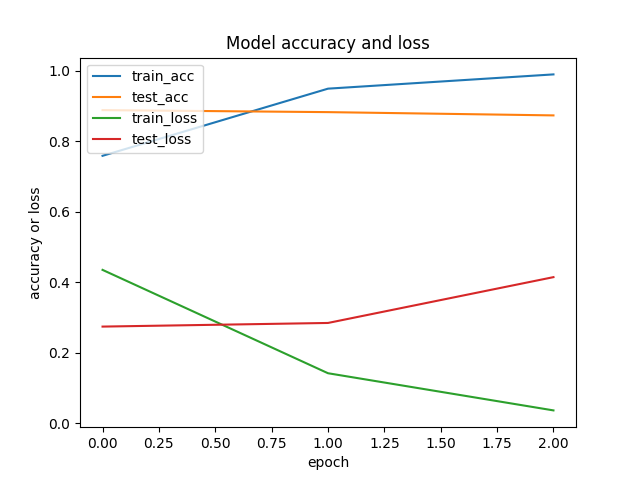

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,2,False,True,96,True,0.86608


<IPython.core.display.Javascript object>


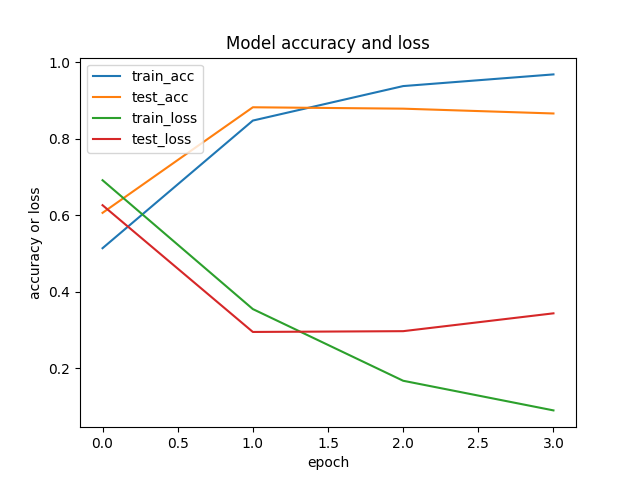

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,2,False,True,96,False,0.87388


<IPython.core.display.Javascript object>


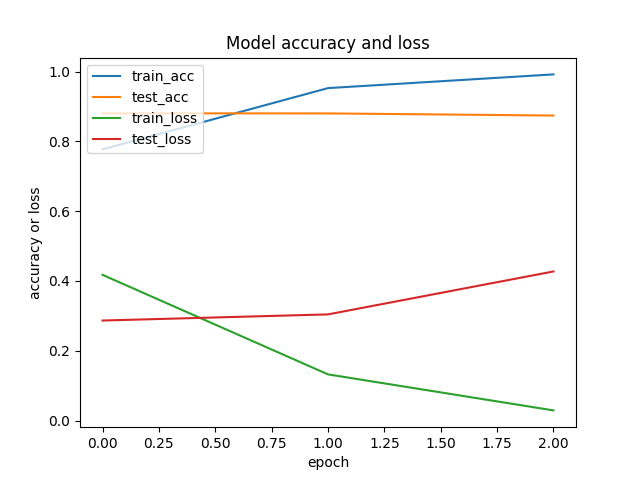

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,0,True,True,48,True,0.88416


<IPython.core.display.Javascript object>


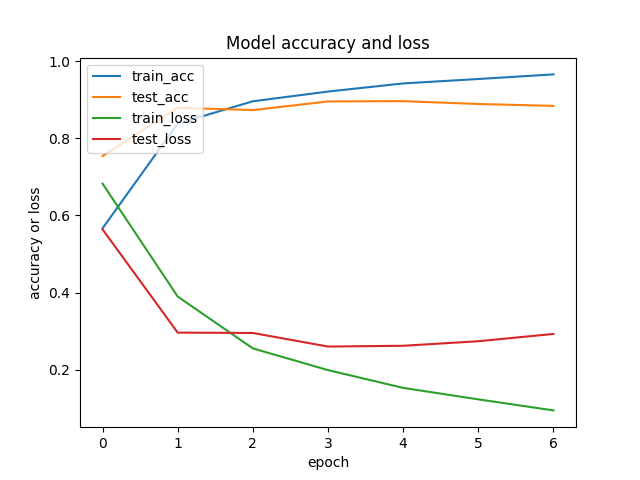

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,0,True,True,48,False,0.87896


<IPython.core.display.Javascript object>


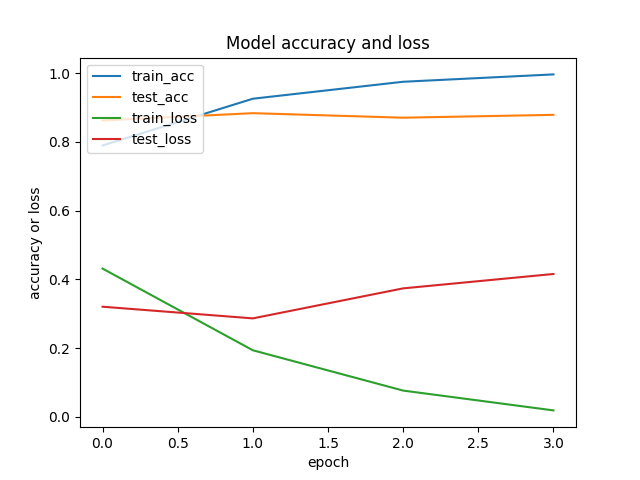

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,0,True,True,96,True,0.88696


<IPython.core.display.Javascript object>


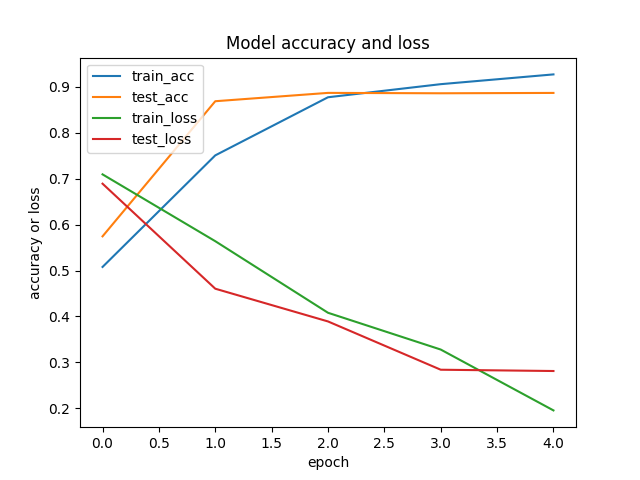

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,0,True,True,96,False,0.88432


<IPython.core.display.Javascript object>


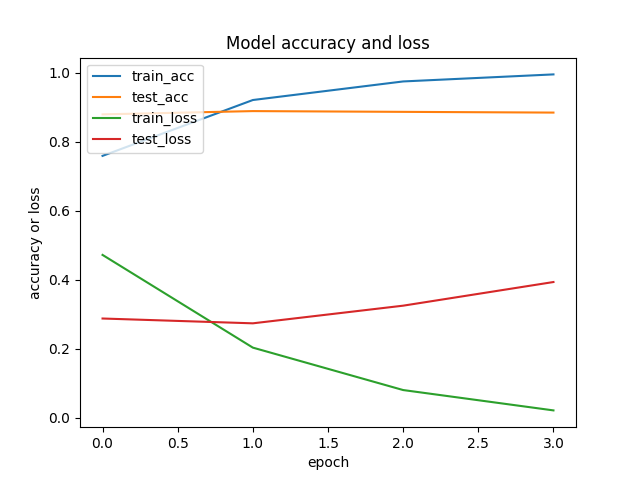

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,0,True,False,48,True,0.83224


<IPython.core.display.Javascript object>


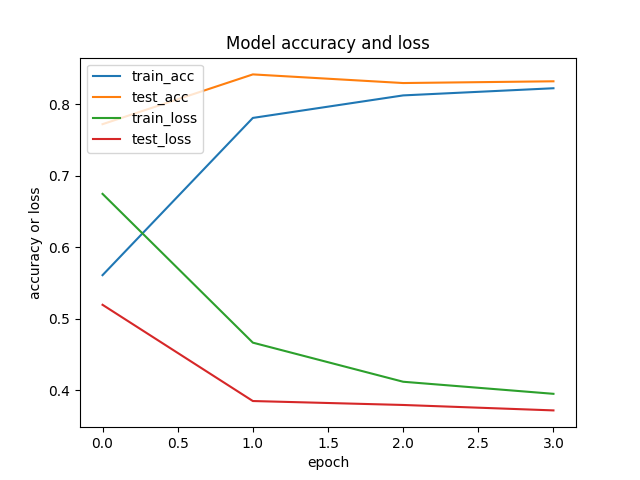

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,0,True,False,48,False,0.86172


<IPython.core.display.Javascript object>


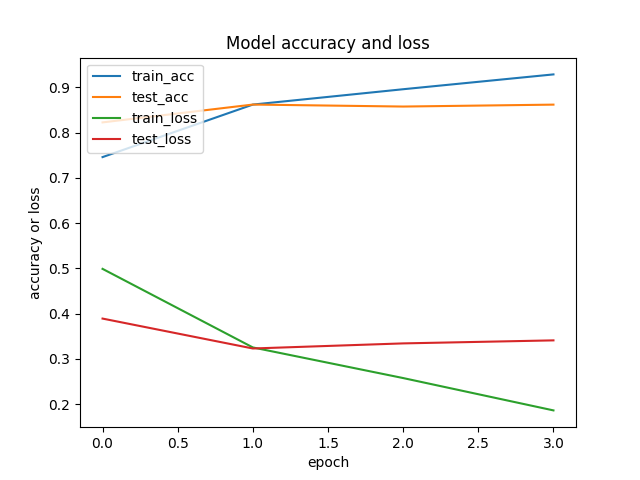

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,0,True,False,96,True,0.87312


<IPython.core.display.Javascript object>


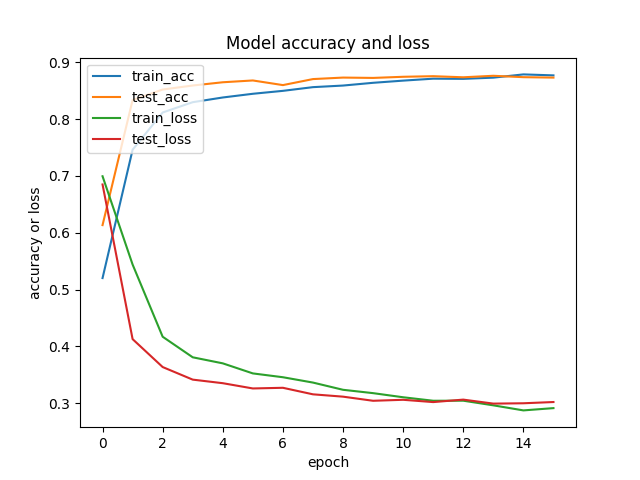

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,0,True,False,96,False,0.8552


<IPython.core.display.Javascript object>


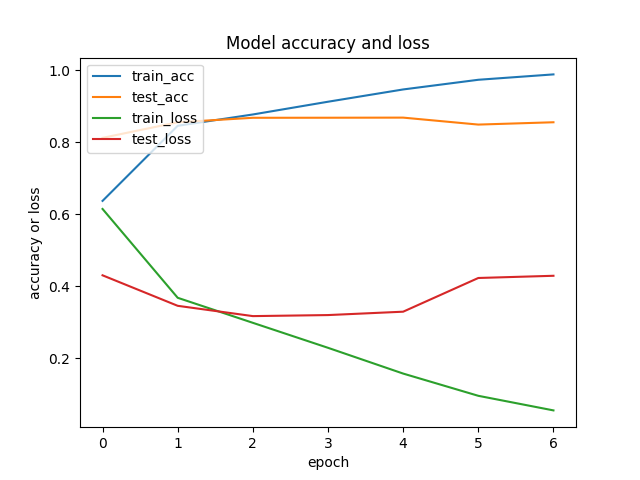

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,0,False,True,48,True,0.86732


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


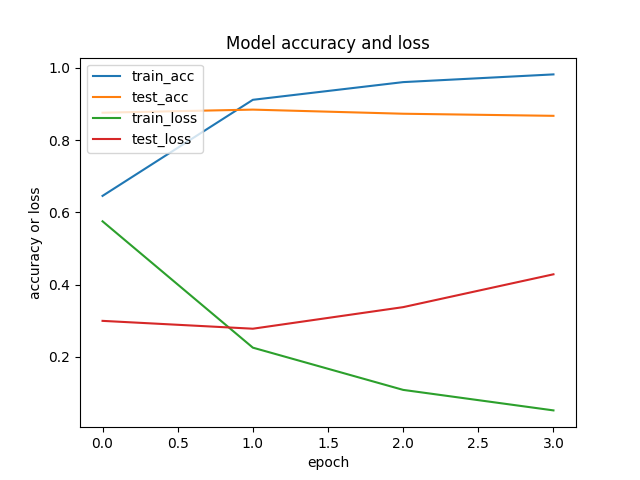

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,0,False,True,48,False,0.86712


<IPython.core.display.Javascript object>


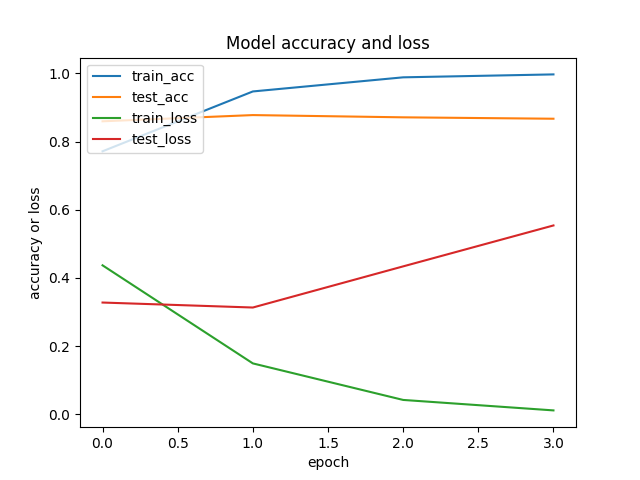

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,0,False,True,96,True,0.87224


<IPython.core.display.Javascript object>


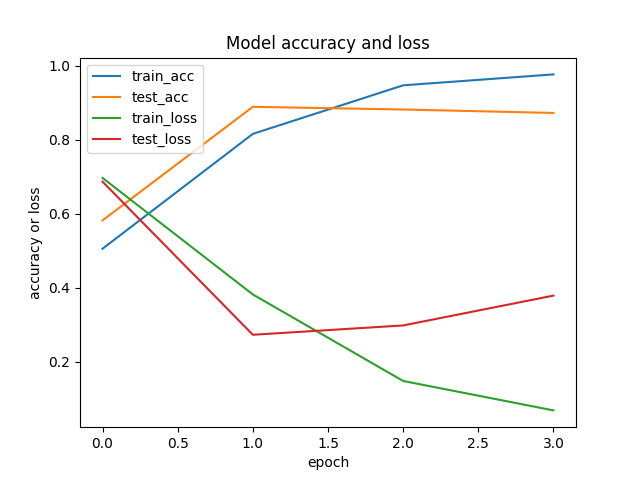

,use_cleaned_docs,number_of_additional_conv_layers,use_pre_trained_embedding,trainable_for_embedding,number_of_filters,use_dropout,val_acc
0,False,0,False,True,96,False,0.87


<IPython.core.display.Javascript object>


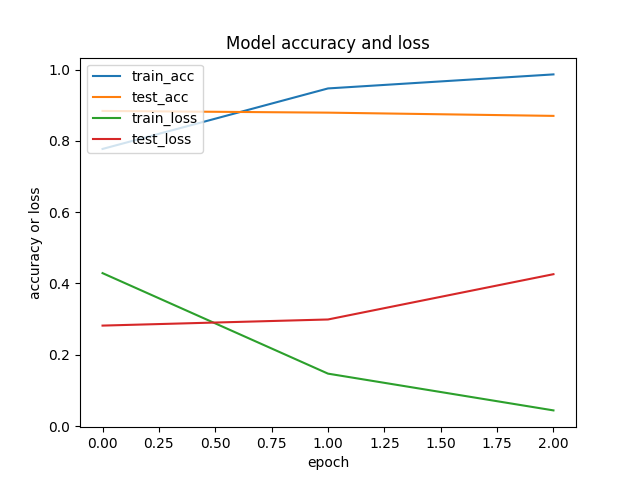

In [19]:
%matplotlib notebook

import matplotlib.pyplot as plt

for history, exp_cond in zip(exp_result, exp_conditions):
    exp_cond['val_acc'] = history.history['val_acc'][-1]
    columns_display = ['use_cleaned_docs','number_of_additional_conv_layers', 'use_pre_trained_embedding', 'trainable_for_embedding','number_of_filters','use_dropout','val_acc']
    exp_cond_row_df = pd.DataFrame([exp_cond], columns=columns_display)
    display(exp_cond_row_df)
    
    plt.figure()
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('Model accuracy and loss')
    plt.ylabel('accuracy or loss')
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'test_acc', 'train_loss', 'test_loss'], loc='upper left')
    plt.show()
    
    
    # Plot training & validation loss values
#     plt.figure()
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('Model loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()

In [17]:
# evaluate
# loss, acc = model.evaluate(x_test, y_test, verbose=0)
# print('Test Accuracy: %f' % (acc*100))